In [ ]:
# Module 02 — Contour Detection & ROI Extraction
Tasks (as in PDF):
- Use OpenCV to detect contours of defects.
- Extract bounding boxes and crop individual defect regions (ROIs).
- Label defect ROIs for model training.

Deliverables:
- ROI extraction pipeline (this notebook)
- Cropped & labeled defect samples stored under data/rois/images/<class>/
- labels.csv mapping roi_filename -> label


In [2]:
# Step 2.1 — imports and paths
from pathlib import Path
import json, csv
import cv2, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# dataset root (adjust if your dataset is elsewhere)
DATASET_ROOT = Path(r"C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET")
IMAGES_ROOT = DATASET_ROOT / "images"
ROTATION_ROOT = DATASET_ROOT / "rotation"

# output locations
OUT_ROOT = Path("data/rois/images")   # will contain class subfolders
OUT_ROOT.mkdir(parents=True, exist_ok=True)
LABELS_CSV = Path("data/rois/labels.csv")

print("Dataset root:", DATASET_ROOT.exists(), DATASET_ROOT)
print("Images root:", IMAGES_ROOT.exists(), IMAGES_ROOT)
print("Rotation root:", ROTATION_ROOT.exists(), ROTATION_ROOT)
print("ROI output root:", OUT_ROOT.resolve())


Dataset root: True C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET
Images root: True C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\images
Rotation root: True C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\rotation
ROI output root: C:\Users\Lavanya R\data\rois\images


In [3]:
# Step 2.2 — preprocessing and ROI helpers (re-usable functions)
def preprocess_and_subtract_gray(template_path, test_path, resize_to=(1024,1024)):
    """
    Load grayscale, optionally resize, compute absdiff, blur, otsu threshold,
    and apply morphological close+open. Returns (diff, mask).
    """
    t = cv2.imread(str(template_path), cv2.IMREAD_GRAYSCALE)
    s = cv2.imread(str(test_path), cv2.IMREAD_GRAYSCALE)
    if t is None or s is None:
        raise ValueError(f"Cannot read images: {template_path}, {test_path}")
    if resize_to:
        t = cv2.resize(t, resize_to)
        s = cv2.resize(s, resize_to)
    diff = cv2.absdiff(s, t)
    diff_blur = cv2.GaussianBlur(diff, (5,5), 0)
    _, th = cv2.threshold(diff_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    return diff, th

def extract_rois_from_mask(test_img_path, mask, min_area=80, pad=6, max_rois=None):
    """
    Given test image path and binary mask, find contours and return list of
    ((x0,y0,x1,y1), crop_bgr) for each defect. Crops are in BGR color.
    """
    img_bgr = cv2.imread(str(test_img_path))
    if img_bgr is None:
        raise ValueError(f"Cannot read test image: {test_img_path}")
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort by contour area (descending) to prioritize big defects
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    rois = []
    for i, cnt in enumerate(contours):
        if max_rois is not None and i >= max_rois:
            break
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        x,y,w,h = cv2.boundingRect(cnt)
        x0 = max(0, x - pad); y0 = max(0, y - pad)
        x1 = min(img_bgr.shape[1], x + w + pad); y1 = min(img_bgr.shape[0], y + h + pad)
        crop = img_bgr[y0:y1, x0:x1]
        rois.append(((x0,y0,x1,y1), crop))
    return rois


In [4]:
# Step 2.3 — iterate over classes, process image pairs, save ROI crops and build labels list
OUT_ROOT.mkdir(parents=True, exist_ok=True)
labels = []  # list of (roi_relpath, label)

classes = sorted([d.name for d in IMAGES_ROOT.iterdir() if d.is_dir()])
print("Detected classes:", classes)

global_idx = 0
# Tune these parameters if you want smaller/larger ROIs
RESIZE_TO = (1024, 1024)
MIN_AREA = 80
PAD = 6
MAX_ROIS_PER_IMAGE = 40  # prevents explosion due to noise

for cls in classes:
    src_dir = IMAGES_ROOT / cls
    rot_dir = ROTATION_ROOT / f"{cls}_rotation"
    if not src_dir.exists() or not rot_dir.exists():
        print(f"Skipping class {cls}: missing pair directories.")
        continue
    out_class_dir = OUT_ROOT / cls
    out_class_dir.mkdir(parents=True, exist_ok=True)
    image_files = sorted([p for p in src_dir.iterdir() if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".tif",".tiff")])
    print(f"Processing class {cls}: {len(image_files)} images")
    for img_path in tqdm(image_files, desc=f"Class {cls}", leave=False):
        fname = img_path.name
        rot_path = rot_dir / fname
        if not rot_path.exists():
            # try case-insensitive match or alternate extensions
            candidates = list(rot_dir.glob(img_path.stem + "*"))
            rot_path = candidates[0] if candidates else None
            if rot_path is None:
                continue
        try:
            _, mask = preprocess_and_subtract_gray(img_path, rot_path, resize_to=RESIZE_TO)
            rois = extract_rois_from_mask(rot_path, mask, min_area=MIN_AREA, pad=PAD, max_rois=MAX_ROIS_PER_IMAGE)
        except Exception as e:
            print("Error processing", img_path.name, "->", e)
            continue
        for i, ((x0,y0,x1,y1), crop) in enumerate(rois):
            global_idx += 1
            roi_name = f"{global_idx:06d}_{cls}_{img_path.stem}_roi{i:02d}.png"
            out_file = out_class_dir / roi_name
            # save as color PNG (ensures consistent 3-channel images)
            cv2.imwrite(str(out_file), crop)
            labels.append((str(Path(cls) / roi_name), cls))

# small summary
print("Total ROIs saved:", global_idx)


Detected classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']
Processing class Missing_hole: 115 images


Processing class Mouse_bite: 115 images


Processing class Open_circuit: 116 images


Processing class Short: 116 images


Processing class Spur: 115 images


Processing class Spurious_copper: 116 images


Total ROIs saved: 27720


In [5]:
# Step 2.4 — write labels.csv and create train/val split
import pandas as pd
from sklearn.model_selection import train_test_split

labels_csv_path = LABELS_CSV
df = pd.DataFrame(labels, columns=["roi_filename","label"])
labels_csv_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(labels_csv_path, index=False)
print("Saved labels CSV:", labels_csv_path, "rows:", len(df))

# Stratified train/val split
train_df, val_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=42)
train_csv = labels_csv_path.parent / "train_labels.csv"
val_csv   = labels_csv_path.parent / "val_labels.csv"
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
print("Train/Val split sizes:", len(train_df), "train |", len(val_df), "val")
print("train_csv:", train_csv)
print("val_csv:", val_csv)


Saved labels CSV: data\rois\labels.csv rows: 27720
Train/Val split sizes: 22176 train | 5544 val
train_csv: data\rois\train_labels.csv
val_csv: data\rois\val_labels.csv


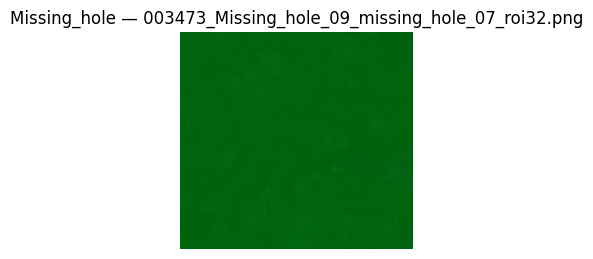

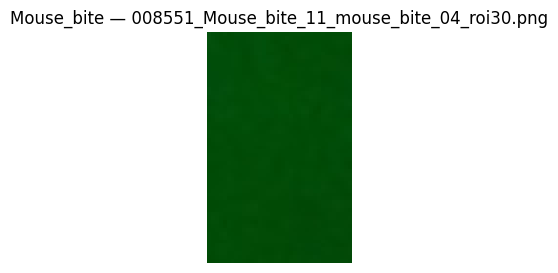

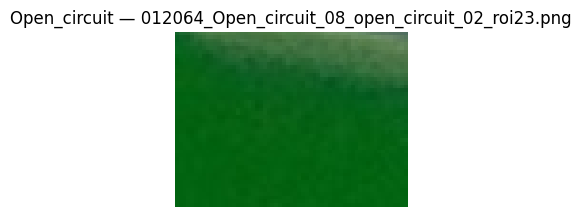

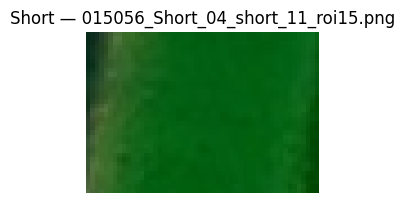

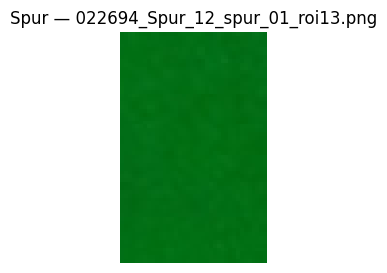

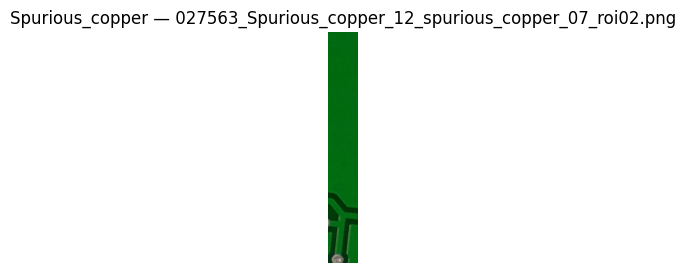

In [6]:
# Step 2.5 — show a few sample ROI crops per class
from PIL import Image
import random
base = OUT_ROOT
classes = sorted([d.name for d in base.iterdir() if d.is_dir()])
for cls in classes:
    samples = list((base/cls).glob("*.png"))
    if not samples:
        continue
    sample = random.choice(samples)
    img = Image.open(sample)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f"{cls} — {sample.name}")
    plt.axis("off")
    plt.show()


In [ ]:
# Tuning & troubleshooting (Module-2)
- If masks produce many tiny ROIs → increase MIN_AREA (e.g., 150 or 300) and/or increase morphological kernel.
- If valid defects are merged or missed → reduce kernel size or decrease CLOSE iterations.
- If images are slightly misaligned → use ECC alignment before subtraction (implement before preprocess_and_subtract_gray).
- MAX_ROIS_PER_IMAGE prevents noisy masks from producing thousands of tiny crops; increase only if needed.
- Check `data/rois/images/<class>/` for balance among classes; you may need augmentation for minority classes.
